## Xgboost

In [ ]:
# Import necessary libraries
!pip install datasets nltk scikit-learn xgboost
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
import xgboost as xgb
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
#Load the Dataset
from datasets import load_dataset
ds = load_dataset("Hello-SimpleAI/HC3", "all")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

HC3.py:   0%|          | 0.00/9.47k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/39.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24322 [00:00<?, ? examples/s]

In [ ]:
#print dataset column
print(ds)
print(ds['train'][0])

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'source'],
        num_rows: 24322
    })
})
{'id': '0', 'question': 'Why is every book I hear about a " NY Times # 1 Best Seller " ? ELI5 : Why is every book I hear about a " NY Times # 1 Best Seller " ? Should n\'t there only be one " # 1 " best seller ? Please explain like I\'m five.', 'human_answers': ['Basically there are many categories of " Best Seller " . Replace " Best Seller " by something like " Oscars " and every " best seller " book is basically an " oscar - winning " book . May not have won the " Best film " , but even if you won the best director or best script , you \'re still an " oscar - winning " film . Same thing for best sellers . Also , IIRC the rankings change every week or something like that . Some you might not be best seller one week , but you may be the next week . I guess even if you do n\'t stay there for long , you still achieved the status . Hence 

In [ ]:
#preprocessing
nltk.download('stopwords')
nltk.download('wordnet')

stop_words_set = set(stopwords.words('english'))
word_lemmatizer = WordNetLemmatizer()

def text_preprocessing_pipeline(data_entry):
    if isinstance(data_entry['human_answers'], list):
        data_entry['human_answers'] = [preprocess_text(answer) for answer in data_entry['human_answers']]
    else:
        data_entry['human_answers'] = preprocess_text(data_entry['human_answers'])

    if isinstance(data_entry['chatgpt_answers'], list):
        data_entry['chatgpt_answers'] = [preprocess_text(answer) for answer in data_entry['chatgpt_answers']]
    else:
        data_entry['chatgpt_answers'] = preprocess_text(data_entry['chatgpt_answers'])

    return data_entry

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()

        text = text.translate(str.maketrans('', '', string.punctuation))

        words = text.split()
        text = ' '.join([word for word in words if word not in stop_words_set])

        text = ' '.join([word_lemmatizer.lemmatize(word) for word in text.split()])

        text = re.sub(r'\d+', '', text)

        text = ' '.join(text.split())

    return text

preprocessed_dataset = ds.map(text_preprocessing_pipeline)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Map:   0%|          | 0/24322 [00:00<?, ? examples/s]

In [ ]:
#Spliting the Dataset
from sklearn.model_selection import train_test_split

human_texts = preprocessed_dataset['train']['human_answers']
ai_texts = preprocessed_dataset['train']['chatgpt_answers']

human_labels = [0] * len(human_texts)
ai_labels = [1] * len(ai_texts)

X = human_texts + ai_texts
y = human_labels + ai_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Training set size: 35023
Validation set size: 3892
Test set size: 9729


In [ ]:
X_train = [' '.join(entry) if isinstance(entry, list) else entry for entry in X_train]
X_val = [' '.join(entry) if isinstance(entry, list) else entry for entry in X_val]
X_test = [' '.join(entry) if isinstance(entry, list) else entry for entry in X_test]

In [ ]:
#Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF Training Data Shape: {X_train_tfidf.shape}")
print(f"TF-IDF Validation Data Shape: {X_val_tfidf.shape}")
print(f"TF-IDF Test Data Shape: {X_test_tfidf.shape}")


TF-IDF Training Data Shape: (35023, 5000)
TF-IDF Validation Data Shape: (3892, 5000)
TF-IDF Test Data Shape: (9729, 5000)


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)

y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print(f"Encoded labels in training data: {set(y_train_encoded)}")
print(f"Encoded labels in validation data: {set(y_val_encoded)}")
print(f"Encoded labels in test data: {set(y_test_encoded)}")

Encoded labels in training data: {0, 1}
Encoded labels in validation data: {0, 1}
Encoded labels in test data: {0, 1}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:18:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.54873
[1]	validation_0-mlogloss:0.46887
[2]	validation_0-mlogloss:0.41388
[3]	validation_0-mlogloss:0.37708
[4]	validation_0-mlogloss:0.35248
[5]	validation_0-mlogloss:0.33158
[6]	validation_0-mlogloss:0.31218
[7]	validation_0-mlogloss:0.29992
[8]	validation_0-mlogloss:0.28648
[9]	validation_0-mlogloss:0.27686
[10]	validation_0-mlogloss:0.26726
[11]	validation_0-mlogloss:0.26042
[12]	validation_0-mlogloss:0.25430
[13]	validation_0-mlogloss:0.24738
[14]	validation_0-mlogloss:0.24067
[15]	validation_0-mlogloss:0.23498
[16]	validation_0-mlogloss:0.23044
[17]	validation_0-mlogloss:0.22585
[18]	validation_0-mlogloss:0.22243
[19]	validation_0-mlogloss:0.21820
[20]	validation_0-mlogloss:0.21365
[21]	validation_0-mlogloss:0.21057
[22]	validation_0-mlogloss:0.20766
[23]	validation_0-mlogloss:0.20579
[24]	validation_0-mlogloss:0.20232
[25]	validation_0-mlogloss:0.19998
[26]	validation_0-mlogloss:0.19834
[27]	validation_0-mlogloss:0.19633
[28]	validation_0-mlogloss:0.1

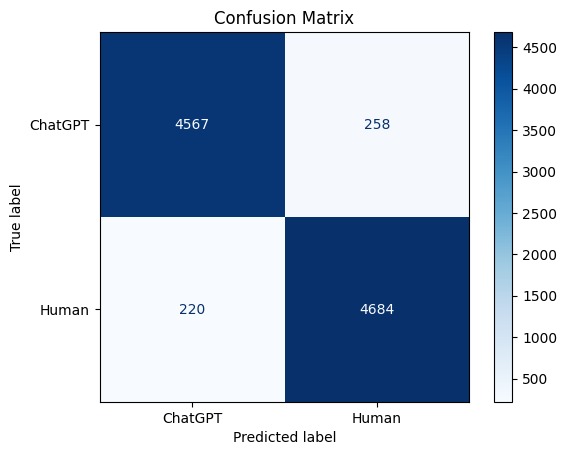

In [ ]:
#Traing the model
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

num_classes = len(label_encoder.classes_)

model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, eval_metric='mlogloss', use_label_encoder=False)

model.fit(X_train_tfidf, y_train_encoded, eval_set=[(X_val_tfidf, y_val_encoded)], verbose=True)

y_pred_val = model.predict(X_val_tfidf)
y_pred_test = model.predict(X_test_tfidf)

print("Validation Accuracy:", accuracy_score(y_val_encoded, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test_encoded, y_pred_test))

print("\nValidation Classification Report:")
print(classification_report(y_val_encoded, y_pred_val))

print("\nTest Classification Report:")
print(classification_report(y_test_encoded, y_pred_test))


conf_matrix = confusion_matrix(y_test_encoded, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['ChatGPT', 'Human'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [ ]:

import joblib

joblib.dump(model, 'xgb_model.pkl')
print("Model saved as 'xgb_model.pkl'")

joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
print("Vectorizer saved as 'tfidf_vectorizer.pkl'")

joblib.dump(label_encoder, 'label_encoder.pkl')
print("Label Encoder saved as 'label_encoder.pkl'")


Model saved as 'xgb_model.pkl'
Vectorizer saved as 'tfidf_vectorizer.pkl'
Label Encoder saved as 'label_encoder.pkl'


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:25:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-mlogloss:0.68756	eval-mlogloss:0.68775
[1]	train-mlogloss:0.68209	eval-mlogloss:0.68245
[2]	train-mlogloss:0.67673	eval-mlogloss:0.67726
[3]	train-mlogloss:0.67147	eval-mlogloss:0.67218
[4]	train-mlogloss:0.66630	eval-mlogloss:0.66720
[5]	train-mlogloss:0.66124	eval-mlogloss:0.66229
[6]	train-mlogloss:0.65627	eval-mlogloss:0.65752
[7]	train-mlogloss:0.65139	eval-mlogloss:0.65280
[8]	train-mlogloss:0.64660	eval-mlogloss:0.64821
[9]	train-mlogloss:0.64189	eval-mlogloss:0.64368
[10]	train-mlogloss:0.63728	eval-mlogloss:0.63922
[11]	train-mlogloss:0.63274	eval-mlogloss:0.63487
[12]	train-mlogloss:0.62828	eval-mlogloss:0.63061
[13]	train-mlogloss:0.62391	eval-mlogloss:0.62638
[14]	train-mlogloss:0.61961	eval-mlogloss:0.62226
[15]	train-mlogloss:0.61537	eval-mlogloss:0.61819
[16]	train-mlogloss:0.61122	eval-mlogloss:0.61417
[17]	train-mlogloss:0.60713	eval-mlogloss:0.61025
[18]	train-mlogloss:0.60311	eval-mlogloss:0.60638
[19]	train-mlogloss:0.59916	eval-mlogloss:0.60258
[20]	train

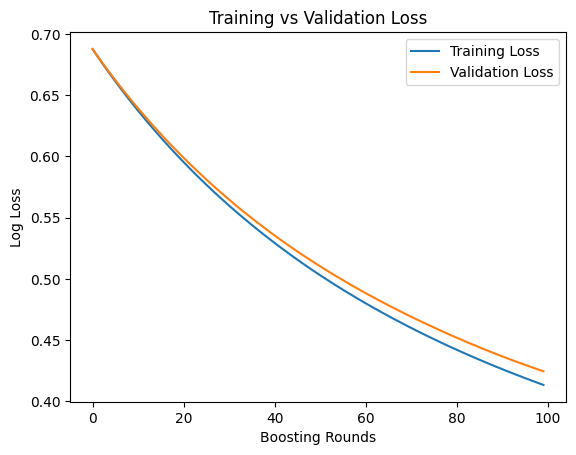

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_tfidf, label=y_train_encoded)
dval = xgb.DMatrix(X_val_tfidf, label=y_val_encoded)

params = {
    'objective': 'multi:softmax',
    'num_class': num_classes,
    'eval_metric': 'mlogloss',
    'max_depth': 5,
    'eta': 0.01,
    'n_estimators': 1000
}

evals = [(dtrain, 'train'), (dval, 'eval')]

evals_result = {}
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=evals,
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=True
)

y_train_pred = bst.predict(dtrain)
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print(f'Training Accuracy: {train_accuracy:.4f}')

print(f"Training Loss: {evals_result['train']['mlogloss']}")
print(f"Validation Loss: {evals_result['eval']['mlogloss']}")

epochs = len(evals_result['train']['mlogloss'])
plt.plot(range(epochs), evals_result['train']['mlogloss'], label='Training Loss')
plt.plot(range(epochs), evals_result['eval']['mlogloss'], label='Validation Loss')

plt.xlabel('Boosting Rounds')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()


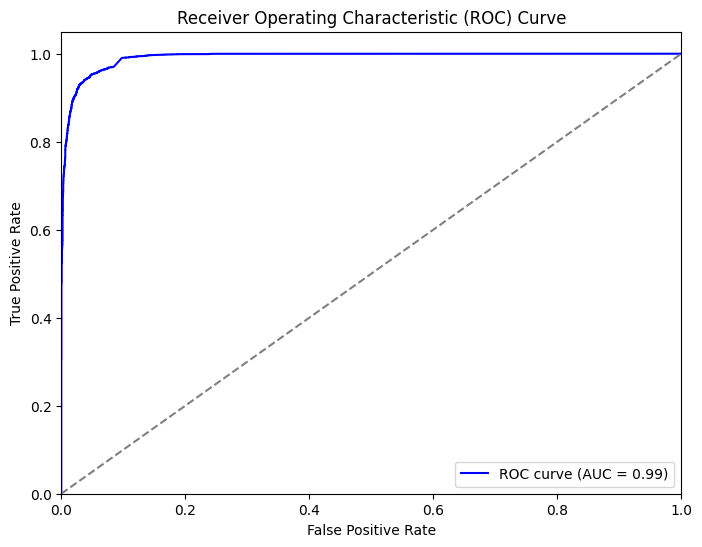

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_tfidf)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

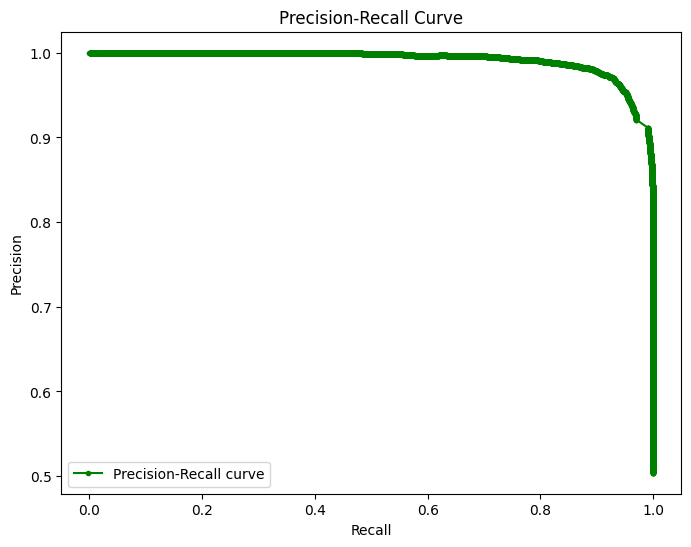

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test_tfidf)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', marker='.', label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


<Figure size 1000x600 with 0 Axes>

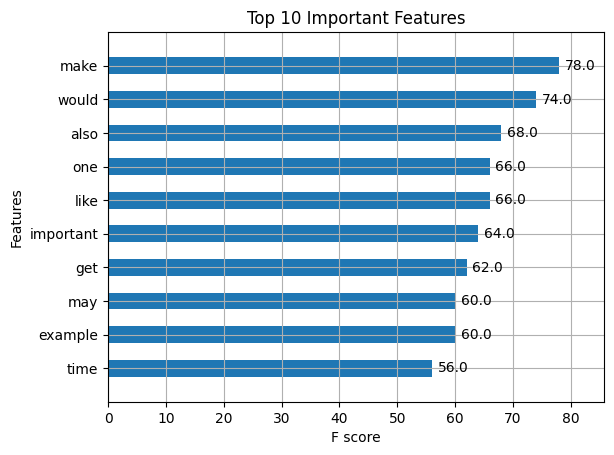

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you've already trained your XGBoost model and have the 'model' variable

# Get feature names from TF-IDF vectorizer
feature_names = vectorizer.get_feature_names_out()

# Plot importance with feature names
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, importance_type='weight', max_num_features=10, height=0.5)

# Update the y-axis labels to show the feature names instead of numbers
plt.gca().set_yticklabels([feature_names[int(i.get_text()[1:])] for i in plt.gca().get_yticklabels()])
plt.title('Top 10 Important Features')
plt.show()


y_train type: <class 'numpy.ndarray'>
y_train unique values: [0 1]


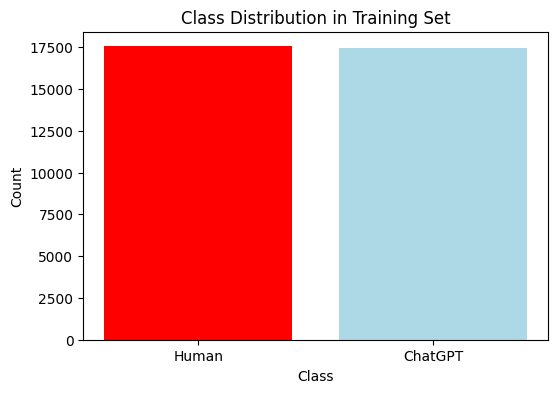

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_train = np.array(y_train)

print(f"y_train type: {type(y_train)}")
print(f"y_train unique values: {np.unique(y_train)}")

plt.figure(figsize=(6, 4))
plt.bar(['Human', 'ChatGPT'], [sum(y_train == 0), sum(y_train == 1)], color=['red', 'lightblue'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Set')
plt.show()

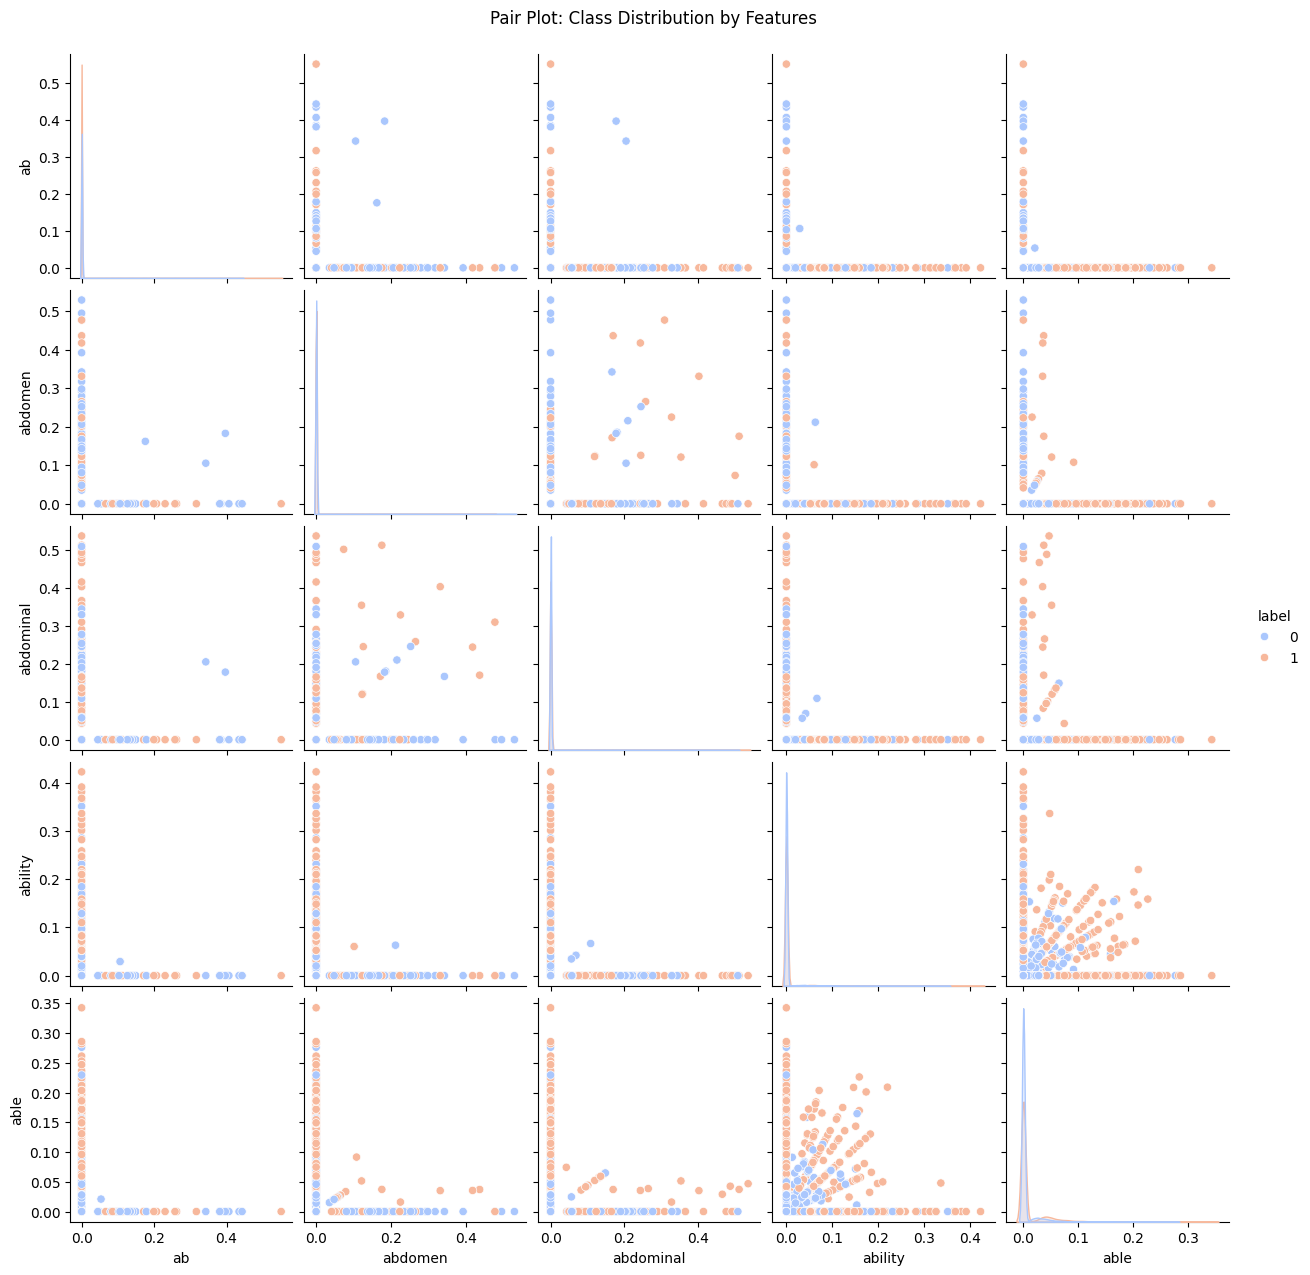

In [ ]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(X_train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
df['label'] = y_train
sns.pairplot(df, hue='label', palette='coolwarm', vars=df.columns[:5])
plt.suptitle("Pair Plot: Class Distribution by Features", y=1.02)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


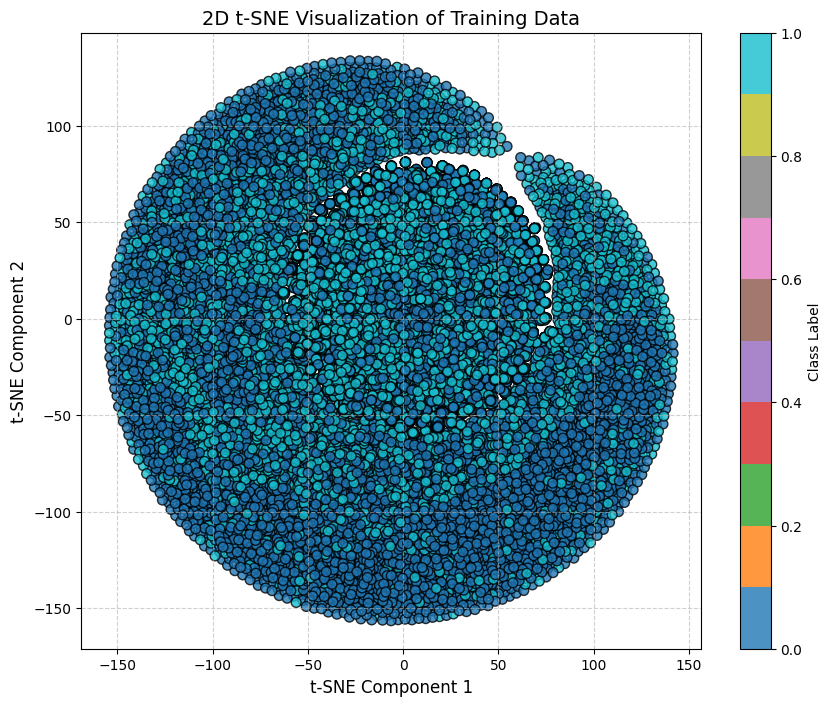

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_train_tsne = tsne.fit_transform(X_train_tfidf.toarray())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_train_tsne[:, 0],
    X_train_tsne[:, 1],
    c=y_train,
    cmap='tab10',
    alpha=0.8,
    edgecolors='k',
    s=50
)
plt.colorbar(scatter, label='Class Label')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('2D t-SNE Visualization of Training Data', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
model = joblib.load('xgb_model.pkl')
print("Model loaded successfully!")
vectorizer = joblib.load('tfidf_vectorizer.pkl')
print("Vectorizer loaded successfully!")
label_encoder = joblib.load('label_encoder.pkl')
print("Label Encoder loaded successfully!")

Model loaded successfully!
Vectorizer loaded successfully!
Label Encoder loaded successfully!


In [ ]:
X_train_tfidf = vectorizer.fit_transform(X_train)

In [ ]:
import random

random_indices = random.sample(range(len(X_test)), 100)
sample_sentences = [X_test[i] for i in random_indices]
sample_true_labels = [y_test_encoded[i] for i in random_indices]
sample_predicted_labels = [y_pred_test[i] for i in random_indices]

label_mapping = {0: 'ChatGPT', 1: 'Human'}

print("Random 10 Predictions with Correctness Highlighting:\n")
for idx, (sentence, true_label, predicted_label) in enumerate(zip(sample_sentences, sample_true_labels, sample_predicted_labels)):
    true_label_text = label_mapping[true_label]
    predicted_label_text = label_mapping[predicted_label]

    correctness = "Correct ✅" if true_label == predicted_label else "Incorrect ❌"
    color_start = "\033[92m" if true_label == predicted_label else "\033[91m"  # Green for correct, Red for incorrect
    color_end = "\033[0m"

    print(f"Sample {idx + 1}:")
    print(f"Sentence: {sentence}")
    print(f"{color_start}True Label: {true_label_text} | Predicted Label: {predicted_label_text} | {correctness}{color_end}")
    print("-" * 80)


Random 10 Predictions with Correctness Highlighting:

Sample 1:
Sentence: long story short net framework bunch premade function microsoft language c asp etc like cooking food framework kitchen pot stove want make meatball first make pot pan mention putting together stove going take long time already focus making dish net framework application development like said also dependency package program run computerwhich need framework run net dependent program think two part imagine net developer nbsp development net contains large set program call program program contain simple function like join two array complex function like translate voice text recognize red object imageimage analysis etc provide functionality make internet application mobile application etc alot providedyou call function program net library soo vast program robot arduino etc develop signal processing image analysis large set web application framework etc visit url nbsp nbsp maintains common language underneath allows pr

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import numpy as np


param_distributions = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 500],
    'colsample_bytree': [0.3, 0.5, 0.7, 1.0],
    'subsample': [0.5, 0.7, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1, 10],
}


xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=2,
    eval_metric='mlogloss',
    use_label_encoder=False
)


random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring='accuracy',
    cv=2,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train_tfidf, y_train_encoded)


print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Accuracy:", random_search.best_score_)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:10:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 1.0, 'reg_lambda': 0.01, 'reg_alpha': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 0.5}
Best Cross-Validation Accuracy: 0.9517460443646216


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:31:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:0.60830
[1]	validation_0-mlogloss:0.54904
[2]	validation_0-mlogloss:0.50772
[3]	validation_0-mlogloss:0.46752
[4]	validation_0-mlogloss:0.43581
[5]	validation_0-mlogloss:0.41017
[6]	validation_0-mlogloss:0.38977
[7]	validation_0-mlogloss:0.37340
[8]	validation_0-mlogloss:0.35603
[9]	validation_0-mlogloss:0.34401
[10]	validation_0-mlogloss:0.33214
[11]	validation_0-mlogloss:0.32309
[12]	validation_0-mlogloss:0.31366
[13]	validation_0-mlogloss:0.30543
[14]	validation_0-mlogloss:0.29839
[15]	validation_0-mlogloss:0.29257
[16]	validation_0-mlogloss:0.28653
[17]	validation_0-mlogloss:0.28129
[18]	validation_0-mlogloss:0.27711
[19]	validation_0-mlogloss:0.27315
[20]	validation_0-mlogloss:0.26763
[21]	validation_0-mlogloss:0.26300
[22]	validation_0-mlogloss:0.25890
[23]	validation_0-mlogloss:0.25559
[24]	validation_0-mlogloss:0.25126
[25]	validation_0-mlogloss:0.24796
[26]	validation_0-mlogloss:0.24505
[27]	validation_0-mlogloss:0.24254
[28]	validation_0-mlogloss:0.2

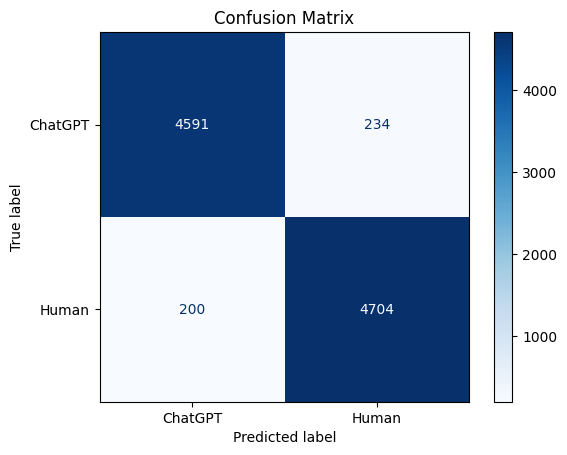

In [ ]:
# Training the model with tuned hyperparameters
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Best parameters from RandomizedSearchCV
best_params = {
    'subsample': 1.0,
    'reg_lambda': 0.01,
    'reg_alpha': 1,
    'n_estimators': 200,
    'max_depth': 5,
    'learning_rate': 0.2,
    'gamma': 0,
    'colsample_bytree': 0.5
}

num_classes = len(label_encoder.classes_)

model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    eval_metric='mlogloss',
    use_label_encoder=False,
    **best_params
)

model.fit(X_train_tfidf, y_train_encoded, eval_set=[(X_val_tfidf, y_val_encoded)], verbose=True)

y_pred_val = model.predict(X_val_tfidf)
y_pred_test = model.predict(X_test_tfidf)

print("Validation Accuracy:", accuracy_score(y_val_encoded, y_pred_val))
print("Test Accuracy:", accuracy_score(y_test_encoded, y_pred_test))

print("\nValidation Classification Report:")
print(classification_report(y_val_encoded, y_pred_val))

print("\nTest Classification Report:")
print(classification_report(y_test_encoded, y_pred_test))


conf_matrix = confusion_matrix(y_test_encoded, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['ChatGPT', 'Human'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


##ALBERT


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

def tokenize_texts(texts, tokenizer, max_length=512):
    return tokenizer(
        texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt"
    )


X_train = [item for sublist in X_train for item in sublist] if isinstance(X_train[0], list) else X_train
X_val = [item for sublist in X_val for item in sublist] if isinstance(X_val[0], list) else X_val
X_test = [item for sublist in X_test for item in sublist] if isinstance(X_test[0], list) else X_test

X_train = [str(text).strip() for text in X_train if text and str(text).strip()]
X_val = [str(text).strip() for text in X_val if text and str(text).strip()]
X_test = [str(text).strip() for text in X_test if text and str(text).strip()]

train_encodings = tokenize_texts(X_train, tokenizer)
val_encodings = tokenize_texts(X_val, tokenizer)
test_encodings = tokenize_texts(X_test, tokenizer)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [ ]:
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item


train_dataset = TextDataset(train_encodings, y_train)
val_dataset = TextDataset(val_encodings, y_val)
test_dataset = TextDataset(test_encodings, y_test)


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=2)


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    run_name="run_name1",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    report_to="none"
    )


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments, TrainerCallback
from google.colab import drive
import os
import json

drive.mount('/content/drive')

output_dir = "/content/drive/My Drive/loss_logs/"
os.makedirs(output_dir, exist_ok=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

class LossCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.training_losses.append(logs["loss"])
            if "eval_loss" in logs:
                self.validation_losses.append(logs["eval_loss"])

loss_callback = LossCallback()

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    logging_steps=200,
    save_steps=200,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[loss_callback],
)

trainer.train()

loss_log_file = os.path.join(output_dir, "loss_logs.json")
with open(loss_log_file, "w") as f:
    json.dump({
        "training_losses": loss_callback.training_losses,
        "validation_losses": loss_callback.validation_losses,
    }, f)

print(f"Loss logs saved to {loss_log_file}")

with open(loss_log_file, "r") as f:
    loaded_logs = json.load(f)

print("Loaded Logs:", loaded_logs)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-9-213ad6876e2e>:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-6-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy
200,0.708200,0.721587,0.499229
400,0.705600,0.694901,0.499229
600,0.703200,0.750082,0.499229
800,0.714700,0.693571,0.499229
1000,0.699800,0.707670,0.500771
1200,0.703300,0.693186,0.499229
1400,0.704100,0.698606,0.499229
1600,0.704000,0.693488,0.500771
1800,0.701100,0.693438,0.500771
2000,0.700700,0.698603,0.499229


<ipython-input-6-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-6-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-6-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-6-ab43b25f4758>:13: UserWarning: To copy construct from a 

Loss logs saved to /content/drive/My Drive/loss_logs/loss_logs.json
Loaded Logs: {'training_losses': [0.7082, 0.7056, 0.7032, 0.7147, 0.6998, 0.7033, 0.7041, 0.704, 0.7011, 0.7007, 0.7023, 0.7073, 0.7039, 0.7012, 0.6981, 0.6991, 0.6994, 0.7053, 0.703, 0.7001, 0.7018, 0.6977, 0.6985, 0.7043, 0.6996, 0.6997, 0.6992, 0.6982, 0.7007, 0.6988, 0.6983, 0.6967], 'validation_losses': [0.7215872406959534, 0.6949010491371155, 0.7500816583633423, 0.6935712099075317, 0.7076702117919922, 0.6931858658790588, 0.6986061334609985, 0.6934875845909119, 0.6934382915496826, 0.6986027359962463, 0.6932054162025452, 0.694477915763855, 0.6953720450401306, 0.6932012438774109, 0.6981439590454102, 0.6948384046554565, 0.6931730508804321, 0.6970928311347961, 0.69459468126297, 0.6937243342399597, 0.6931698322296143, 0.6966501474380493, 0.6977482438087463, 0.6934788227081299, 0.7001725435256958, 0.6934472918510437, 0.6956966519355774, 0.6931995153427124, 0.6952627897262573, 0.6931502819061279, 0.69322669506073, 0.6937

In [ ]:
model.save_pretrained("/content/drive/MyDrive/fine_tuned_model")
tokenizer.save_pretrained("/content/drive/MyDrive/fine_tuned_model")

('/content/drive/MyDrive/fine_tuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/fine_tuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/fine_tuned_model/spiece.model',
 '/content/drive/MyDrive/fine_tuned_model/added_tokens.json',
 '/content/drive/MyDrive/fine_tuned_model/tokenizer.json')

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_model")

tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/fine_tuned_model")


In [ ]:
from transformers import Trainer, TrainingArguments, TrainerCallback
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

class LossCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.training_losses.append(logs["loss"])
            if "eval_loss" in logs:
                self.validation_losses.append(logs["eval_loss"])

loss_callback = LossCallback()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[loss_callback],
)

<ipython-input-16-d16a17ad07cc>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<ipython-input-6-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Test Accuracy: 0.5034
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.01      0.02      4825
           1       0.50      0.99      0.67      4904

    accuracy                           0.50      9729
   macro avg       0.49      0.50      0.35      9729
weighted avg       0.49      0.50      0.35      9729



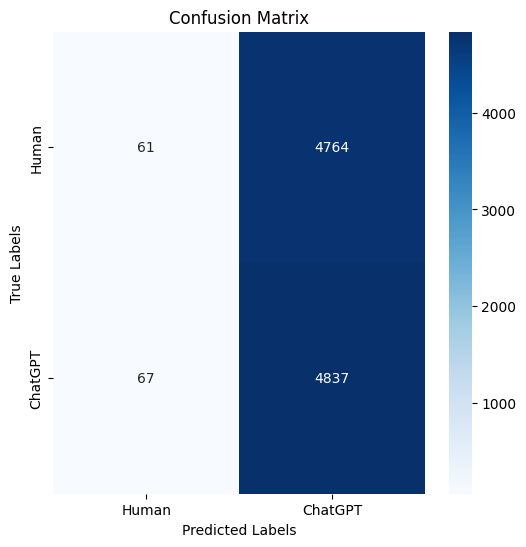

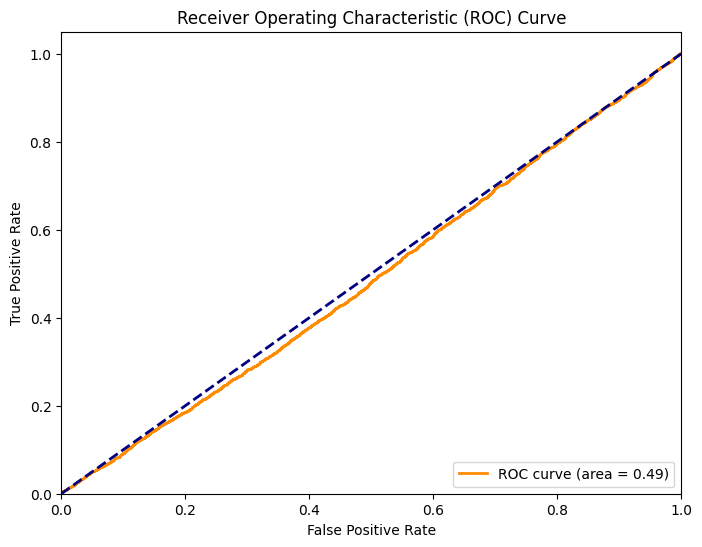

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report

def evaluate_model(trainer, test_dataset):
    predictions = trainer.predict(test_dataset)

    y_pred = np.argmax(predictions.predictions, axis=-1)
    y_true = predictions.label_ids

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")

    print("Classification Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Human", "ChatGPT"], yticklabels=["Human", "ChatGPT"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, predictions.predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

evaluate_model(trainer, test_dataset)

In [ ]:
def print_training_logs(trainer):
    logs = trainer.state.log_history

    for log in logs:
        print(log)

print_training_logs(trainer)

In [ ]:
import torch
from termcolor import colored

def predict_and_highlight(model, test_dataset, tokenizer, batch_size=16):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    model.eval()

    all_preds = []
    all_labels = []
    all_sentences = []
    with torch.no_grad():
        for batch in test_loader:
            inputs = {key: val.to(next(model.parameters()).device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(next(model.parameters()).device)

            sentences = batch["input_ids"]
            decoded_sentences = tokenizer.batch_decode(sentences, skip_special_tokens=True)
            all_sentences.extend(decoded_sentences)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    print("Test Predictions:")
    for i, (pred, label, sentence) in enumerate(zip(all_preds, all_labels, all_sentences)):
        if i >= 50:
            break

        print(f"Sample {i}:")
        print(f"Sentence: {sentence}")
        print(f"True Label: {'ChatGPT' if label == 1 else 'Human'} | Predicted Label: {'ChatGPT' if pred == 1 else 'Human'}", end=" ")

        if pred == label:
            print(colored("Correct ✅", "green"))
        else:
            print(colored("Wrong ❌", "red"))

        print("-" * 80)

predict_and_highlight(model, test_dataset, tokenizer)

<ipython-input-6-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Test Predictions:
Sample 0:
Sentence: giant phonebook provides information anything linked use phonebook hook computer use phonebook look detail someone else also store look password make sure say giant phonebook also classifies people listing little tiny phonebook like yellow page make thing lot easier organize optional
True Label: Human | Predicted Label: ChatGPT Wrong ❌
--------------------------------------------------------------------------------
Sample 1:
Sentence: op sp need tlas watr tldr idkaaldap
True Label: ChatGPT | Predicted Label: ChatGPT Correct ✅
--------------------------------------------------------------------------------
Sample 2:
Sentence: computer like home nt share lot information list use computer list good computer lot computer try tell computer log computer individually get difficult especially change made ldap ldap lightweight directory access protocol important way tell many different computer set thing best part make change ldap computer asks ldap informa

# Distillbert


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
def tokenize_texts(texts, tokenizer, max_length=512):
    return tokenizer(
        texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt"
    )


X_train = [item for sublist in X_train for item in sublist] if isinstance(X_train[0], list) else X_train
X_val = [item for sublist in X_val for item in sublist] if isinstance(X_val[0], list) else X_val
X_test = [item for sublist in X_test for item in sublist] if isinstance(X_test[0], list) else X_test

X_train = [str(text).strip() for text in X_train if text and str(text).strip()]
X_val = [str(text).strip() for text in X_val if text and str(text).strip()]
X_test = [str(text).strip() for text in X_test if text and str(text).strip()]

train_encodings = tokenize_texts(X_train, tokenizer)
val_encodings = tokenize_texts(X_val, tokenizer)
test_encodings = tokenize_texts(X_test, tokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = TextDataset(train_encodings, y_train)
val_dataset = TextDataset(val_encodings, y_val)
test_dataset = TextDataset(test_encodings, y_test)

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    run_name="run_name1",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_total_limit=2,
    report_to="none"
    )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from sklearn.metrics import accuracy_score
from transformers import Trainer, TrainingArguments, TrainerCallback
from google.colab import drive
import os
import json


output_dir = "/content/drive/My Drive/loss_logs/"
os.makedirs(output_dir, exist_ok=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

class LossCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.training_losses.append(logs["loss"])
            if "eval_loss" in logs:
                self.validation_losses.append(logs["eval_loss"])

loss_callback = LossCallback()

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    logging_steps=200,
    save_steps=200,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    load_best_model_at_end=True,

    report_to="none"
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[loss_callback],
)

trainer.train()

loss_log_file = os.path.join(output_dir, "loss_logs.json")
with open(loss_log_file, "w") as f:
    json.dump({
        "training_losses": loss_callback.training_losses,
        "validation_losses": loss_callback.validation_losses,
    }, f)

print(f"Loss logs saved to {loss_log_file}")

with open(loss_log_file, "r") as f:
    loaded_logs = json.load(f)

print("Loaded Logs:", loaded_logs)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-5d10705e4750>:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
<ipython-input-23-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Step,Training Loss,Validation Loss,Accuracy
200,0.697600,0.694319,0.497945
400,0.695100,0.694016,0.499229
600,0.694100,0.707966,0.499229
800,0.703200,0.693149,0.500771
1000,0.694100,0.695764,0.500771
1200,0.694600,0.693142,0.500771
1400,0.694800,0.693181,0.499229
1600,0.693700,0.694003,0.500771
1800,0.693300,0.693146,0.500771
2000,0.693800,0.693154,0.499229


<ipython-input-23-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-23-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-23-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-23-ab43b25f4758>:13: UserWarning: To copy construct fro

Loss logs saved to /content/drive/My Drive/loss_logs/loss_logs.json
Loaded Logs: {'training_losses': [0.6976, 0.6951, 0.6941, 0.7032, 0.6941, 0.6946, 0.6948, 0.6937, 0.6933, 0.6938, 0.6938, 0.6936, 0.6944, 0.6943, 0.6943, 0.6929, 0.6945, 0.6936, 0.6932, 0.6942, 0.6943, 0.6936, 0.6919, 0.6941, 0.6936, 0.6939, 0.6932, 0.6931, 0.6935, 0.6934, 0.6932, 0.6932], 'validation_losses': [0.6943186521530151, 0.694015622138977, 0.707966148853302, 0.693149209022522, 0.6957640051841736, 0.6931419372558594, 0.6931806206703186, 0.6940029859542847, 0.6931459307670593, 0.693153977394104, 0.6932644844055176, 0.6933492422103882, 0.693467378616333, 0.6934140920639038, 0.6938243508338928, 0.6939701437950134, 0.6932775974273682, 0.6935810446739197, 0.6931471228599548, 0.6931868195533752, 0.6931970119476318, 0.693651556968689, 0.6950013041496277, 0.6931482553482056, 0.6939590573310852, 0.6931936740875244, 0.6938344240188599, 0.6936357021331787, 0.6933835744857788, 0.6931611895561218, 0.6932834982872009, 0.693

In [ ]:
model.save_pretrained("/content/drive/MyDrive/fine_tuned_model")
tokenizer.save_pretrained("/content/drive/MyDrive/fine_tuned_model")

('/content/drive/MyDrive/fine_tuned_model/tokenizer_config.json',
 '/content/drive/MyDrive/fine_tuned_model/special_tokens_map.json',
 '/content/drive/MyDrive/fine_tuned_model/vocab.txt',
 '/content/drive/MyDrive/fine_tuned_model/added_tokens.json',
 '/content/drive/MyDrive/fine_tuned_model/tokenizer.json')

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/fine_tuned_model-Distilbert/fine_tuned_model")

tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/fine_tuned_model-Distilbert/fine_tuned_model")


In [ ]:
from transformers import Trainer, TrainingArguments, TrainerCallback
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy}

class LossCallback(TrainerCallback):
    def __init__(self):
        self.training_losses = []
        self.validation_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.training_losses.append(logs["loss"])
            if "eval_loss" in logs:
                self.validation_losses.append(logs["eval_loss"])

loss_callback = LossCallback()
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[loss_callback],
)

<ipython-input-12-d16a17ad07cc>:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


<ipython-input-7-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Test Accuracy: 0.5050
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.03      0.06      4825
           1       0.50      0.97      0.66      4904

    accuracy                           0.50      9729
   macro avg       0.51      0.50      0.36      9729
weighted avg       0.51      0.50      0.37      9729



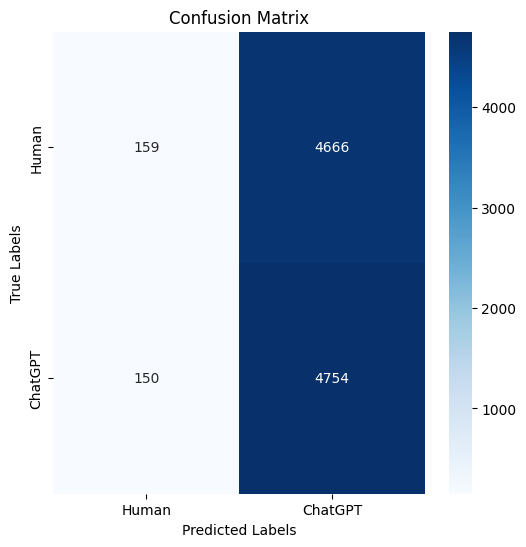

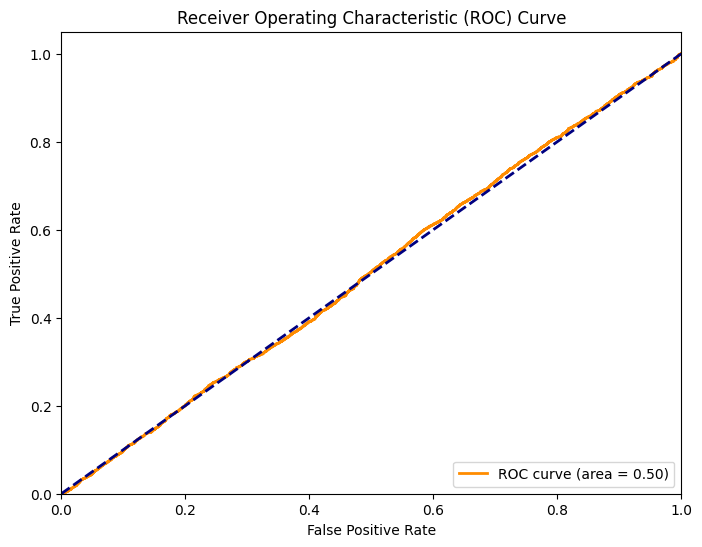

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report

def evaluate_model(trainer, test_dataset):
    predictions = trainer.predict(test_dataset)

    y_pred = np.argmax(predictions.predictions, axis=-1)
    y_true = predictions.label_ids

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Human", "ChatGPT"], yticklabels=["Human", "ChatGPT"])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, predictions.predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

evaluate_model(trainer, test_dataset)


In [ ]:
import json

log_loss_file_path = '/content/drive/MyDrive/loss_logs.json'

with open(log_loss_file_path, 'r') as f:
    log_loss_data = json.load(f)

print(log_loss_data)


{'training_losses': [0.697, 0.6947, 0.6927, 0.6981, 0.6951, 0.6957, 0.6951, 0.6944, 0.6954, 0.6949, 0.6943, 0.6945, 0.6944, 0.6945, 0.6941, 0.6946, 0.6942, 0.6942, 0.6927, 0.6938, 0.6941, 0.6943, 0.6934, 0.694, 0.693, 0.6932, 0.6932, 0.6932, 0.6928, 0.6945, 0.6922, 0.6934], 'validation_losses': [0.6944533586502075, 0.6952476501464844, 0.7119602560997009, 0.6941272020339966, 0.6939437389373779, 0.6932983994483948, 0.6939123868942261, 0.6935058832168579, 0.6934913396835327, 0.6931559443473816, 0.6937478184700012, 0.6933413147926331, 0.694318950176239, 0.6933022737503052, 0.6938331127166748, 0.6934162974357605, 0.6934400200843811, 0.6941716074943542, 0.6931489109992981, 0.6931425333023071, 0.6931859850883484, 0.6936151385307312, 0.6957870721817017, 0.6932908892631531, 0.6947869062423706, 0.6933114528656006, 0.6942573189735413, 0.6936584711074829, 0.6933010220527649, 0.6932461857795715, 0.6932864189147949, 0.6932739019393921]}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


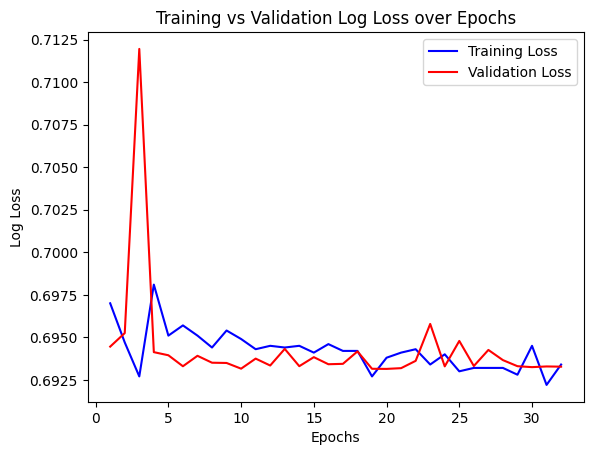

In [ ]:
from google.colab import drive
import json
import matplotlib.pyplot as plt

drive.mount('/content/drive')

log_loss_file_path = '/content/drive/MyDrive/loss_logs.json'

with open(log_loss_file_path, 'r') as f:
    log_loss_data = json.load(f)

training_losses = log_loss_data['training_losses']
validation_losses = log_loss_data['validation_losses']

epochs = range(1, len(training_losses) + 1)

plt.plot(epochs, training_losses, label='Training Loss', color='blue')
plt.plot(epochs, validation_losses, label='Validation Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Log Loss over Epochs')
plt.legend()

plt.show()


In [ ]:
def print_training_logs(trainer):
    logs = trainer.state.log_history

    for log in logs:
        print(log)

print_training_logs(trainer)


{'loss': 0.6976, 'grad_norm': 1.7549835443496704, 'learning_rate': 4.847723465813918e-05, 'epoch': 0.09136592051164916, 'step': 200}
{'eval_loss': 0.6943186521530151, 'eval_accuracy': 0.49794450154162384, 'eval_runtime': 56.5143, 'eval_samples_per_second': 68.867, 'eval_steps_per_second': 4.317, 'epoch': 0.09136592051164916, 'step': 200}
{'loss': 0.6951, 'grad_norm': 0.4547951817512512, 'learning_rate': 4.695446931627836e-05, 'epoch': 0.1827318410232983, 'step': 400}
{'eval_loss': 0.694015622138977, 'eval_accuracy': 0.49922918807810895, 'eval_runtime': 56.5308, 'eval_samples_per_second': 68.847, 'eval_steps_per_second': 4.316, 'epoch': 0.1827318410232983, 'step': 400}
{'loss': 0.6941, 'grad_norm': 0.3898025453090668, 'learning_rate': 4.543170397441754e-05, 'epoch': 0.27409776153494747, 'step': 600}
{'eval_loss': 0.707966148853302, 'eval_accuracy': 0.49922918807810895, 'eval_runtime': 56.4371, 'eval_samples_per_second': 68.962, 'eval_steps_per_second': 4.323, 'epoch': 0.2740977615349474

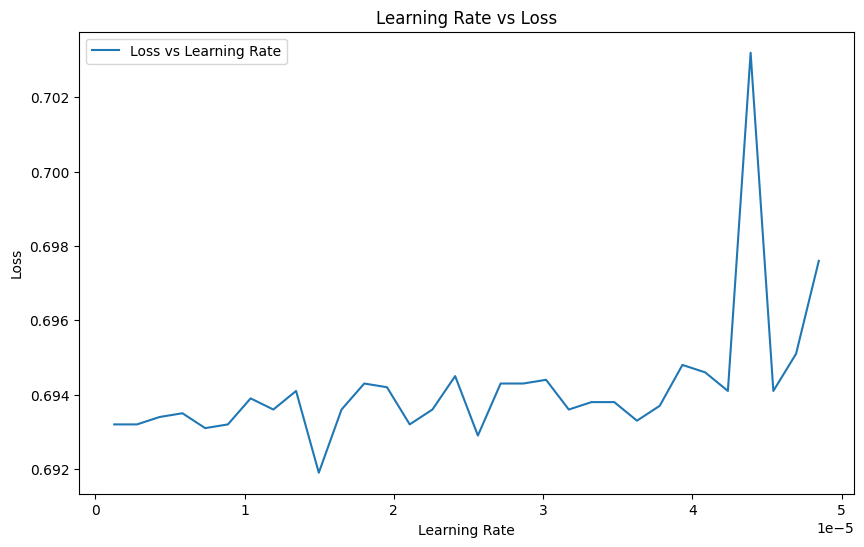

In [ ]:
def plot_lr_vs_loss(trainer):
    lr_values = [log.get("learning_rate") for log in trainer.state.log_history if "learning_rate" in log]
    loss_values = [log.get("loss") for log in trainer.state.log_history if "loss" in log]

    plt.figure(figsize=(10, 6))
    plt.plot(lr_values, loss_values, label="Loss vs Learning Rate")
    plt.title("Learning Rate vs Loss")
    plt.xlabel("Learning Rate")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_lr_vs_loss(trainer)


In [ ]:
import torch

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TextDataset(train_encodings, y_train)
val_dataset = TextDataset(val_encodings, y_val)
test_dataset = TextDataset(test_encodings, y_test)

In [ ]:
import torch
from termcolor import colored

def predict_and_highlight(model, test_dataset, tokenizer, batch_size=16):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    model.eval()

    all_preds = []
    all_labels = []
    all_sentences = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = {key: val.to(next(model.parameters()).device) for key, val in batch.items() if key != "labels"}
            labels = batch["labels"].to(next(model.parameters()).device)

            sentences = batch["input_ids"]
            decoded_sentences = tokenizer.batch_decode(sentences, skip_special_tokens=True)
            all_sentences.extend(decoded_sentences)

            outputs = model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    print("Test Predictions:")
    for i, (pred, label, sentence) in enumerate(zip(all_preds, all_labels, all_sentences)):
        if i >= 50:
            break

        print(f"Sample {i}:")
        print(f"Sentence: {sentence}")
        print(f"True Label: {'ChatGPT' if label == 1 else 'Human'} | Predicted Label: {'ChatGPT' if pred == 1 else 'Human'}", end=" ")

        if pred == label:
            print(colored("Correct ✅", "green"))
        else:
            print(colored("Wrong ❌", "red"))

        print("-" * 80)

predict_and_highlight(model, test_dataset, tokenizer)

<ipython-input-8-ab43b25f4758>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Test Predictions:
Sample 0:
Sentence: giant phonebook provides information anything linked use phonebook hook computer use phonebook look detail someone else also store look password make sure say giant phonebook also classifies people listing little tiny phonebook like yellow page make thing lot easier organize optional
True Label: Human | Predicted Label: ChatGPT Wrong ❌
--------------------------------------------------------------------------------
Sample 1:
Sentence: op sp need tlas watr tldr idkaaldap
True Label: ChatGPT | Predicted Label: ChatGPT Correct ✅
--------------------------------------------------------------------------------
Sample 2:
Sentence: computer like home nt share lot information list use computer list good computer lot computer try tell computer log computer individually get difficult especially change made ldap ldap lightweight directory access protocol important way tell many different computer set thing best part make change ldap computer asks ldap informa